In [66]:
#load required modules
import sys
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import pandas as pd
import datetime
from sodapy import Socrata
import requests
import numpy as np
import re
import seaborn as sns

In [177]:
#create functions to aplly to pandas 
def isdem(permnumber):
    #if a permit starts with DEM its a demolition permit
    dem=re.compile('DEM')
    if dem.match(permnumber)==None:
        return False
    else:
        return True
    
def isuse(permnumber):
    #if a permit starts with USE  its a use permit
    use=re.compile('USE')
    if use.match(permnumber)==None:
        return False
    else:
        return True
def make_lower(nh):
    #make neighborhood names lowercase to ensure match
    if type(nh)==str:
        return nh.lower()
    else:
        return nh
    
def is_drug_charge(row):
    #determine if a drug charge has cds in description or is coded 87 (narcotics)
    cds=re.compile('cds',re.I)
    try:
        if row['incidento'][0:1]=='87':
            return True
        elif cds.search(row['chargedescription'])!=None:
            return True
        else:
            return False
    except:
        return False

def pull_year(dt_obj):
    #determine year from date for group by function
    return dt_obj.year

        

In [2]:
#Connect to api
client = Socrata("data.baltimorecity.gov", None)

In [3]:
#download the victim based crime dataset make into dataframe, make 
#crimedate into a datetime object, make neighborhood lowercase
results = client.get("4ih5-d5d5",limit=300000)
vict_crime=pd.DataFrame.from_records(results)
vict_crime.crimedate=pd.to_datetime(vict_crime.crimedate,yearfirst=True)
vict_crime.neighborhood=vict_crime.neighborhood.apply(make_lower)

In [4]:
#download housing permits, determine if the are use or demolition permits,
#make permit date into a datetime, make the neighborhood lowercase
perm_res=client.get('9t78-k3wf',limit=600000)
ouse_perm_df=pd.DataFrame.from_records(perm_res)
house_perm_df.dateissue=pd.to_datetime(house_perm_df.dateissue,yearfirst=True)
house_perm_df.isdem=house_perm_df.casenum.apply(isdem)
house_perm_df.isuse=house_perm_df.casenum.apply(isuse)
house_perm_df.neighborhood=house_perm_df.neighborhood.apply(make_lower)


In [24]:
#Dowload vacant house dataset, make neighborhood lowercase
vac_res=client.get('rw5h-nvv4',limit=17000)
vac_df=pd.DataFrame.from_records(vac_res)
vac_df.neighborhood=vac_df.neighborhood.apply(make_lower)

In [134]:
#Download arrest data, determine if it is a drug charge, convert date to 
#datetime object, make neighborhood lower case
arrest_res=client.get('icjs-e3jg',limit=160000)
arrest_df=pd.DataFrame.from_records(arrest_res)
arrest_df.is_drugs=arrest_df.apply(is_drug_charge, axis=1)
arrest_df.arrestdate=pd.to_datetime(arrest_df.arrestdate,yearfirst=True)
arrest_df['neighborhood']=arrest_df.name1.apply(make_lower)

In [164]:
#aggregate downloaded data by neighborhood
fig=plt.figure(figsize=(24,24))
ax1=fig.add_subplot(121)
map = Basemap(llcrnrlon=-76.75,llcrnrlat=39.1,urcrnrlon=-76.5,urcrnrlat=39.4,projection='lcc', lat_0=39.25, lon_0=-76.65)
#read shapefile of baltimore neigborhoods, qgis was used to convert projection 
#shape file supplied to a geographic shape file
map.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
#make list of neighborhoods in map
basemap_nhs=list()
for nh in map.hoods_info:
    basemap_nhs.append(nh['Name'].lower())
    
unique_nhs=list(set(basemap_nhs))
unique_meta=list()
#create disctionary of meta data supplied in shape file in addition  to the  data which 
#was collected from the open data site
for nh in unique_nhs:
    meta=map.hoods_info[basemap_nhs.index(nh)]
    meta['Name']=nh
    meta['buildings']=meta['Occupied']+meta['Vacant']
    #assosciate gathered data to each neighborhood
    meta['vict_crime_2012']=vict_crime.crimedate[(vict_crime.crimedate>'1/1/2012') &
                                                 (vict_crime.crimedate<'1/1/2013') & 
                                                 (vict_crime.neighborhood==nh)].count()
    meta['vict_crime_2016']=vict_crime.crimedate[(vict_crime.crimedate>'1/1/2016') & 
                                                 (vict_crime.crimedate<'1/1/2017') &
                                                 (vict_crime.neighborhood==nh)].count()
    
    if meta['vict_crime_2012']>0:
        meta['vict_crime_change']=np.divide(meta['vict_crime_2016']-meta['vict_crime_2012'],
                                            meta['vict_crime_2012'])
    else:
        meta['vict_crime_change']=np.nan
    meta['vac_filled']=house_perm_df.existing_use[(house_perm_df.isuse==True) & 
                                                  (house_perm_df.existing_use=='VAC') & 
                                                  (house_perm_df.neighborhood==nh) &
                                                  (house_perm_df.dateissue>'1/1/2012') &
                                                  (house_perm_df.dateissue<'1/1/2017')].count()
    meta['demo']=house_perm_df.isdem[(house_perm_df.isdem==True) & (house_perm_df.neighborhood==nh)
                                           & (house_perm_df.dateissue>'1/1/2012') &
                                            (house_perm_df.dateissue<'1/1/2017')].count()
    meta['vacant']=vac_df.neighborhood[vac_df.neighborhood==nh].count()
    meta['vac_change']=np.divide(meta['vac_filled']+meta['demo'],meta['vac_filled']+meta['demo']+meta['vacant'])    
    meta['filled_o_vac']=np.divide(meta['vac_filled'],meta['vac_filled']+meta['vacant'])
    meta['drug_crime_2013']=arrest_df.is_drugs[(arrest_df.is_drugs==True) & (arrest_df.arrestdate>'1/1/2013')
                                              & (arrest_df.arrestdate<'1/1/2014') 
                                              & (arrest_df.neighborhood==nh)].count()
    meta['drug_crime_2016']=arrest_df.is_drugs[(arrest_df.is_drugs==True) & (arrest_df.arrestdate>'1/1/2016')
                                              & (arrest_df.arrestdate<'1/1/2017') 
                                              & (arrest_df.neighborhood==nh)].count()
    meta['drug_crime_change']=np.divide(meta['drug_crime_2016']-meta['drug_crime_2013'],meta['drug_crime_2013'])
    unique_meta.append(meta)

/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [233]:
NH_df=pd.DataFrame(unique_meta)
NH_df.Name.apply(make_lower)
#convert rates to percentages
NH_df.vict_crime_change=NH_df.vict_crime_change*100
NH_df.filled_o_vac=NH_df.filled_o_vac*100
NH_df.drug_crime_change=NH_df.drug_crime_change*100
NH_df.Vac_filled_norm=NH_df.vac_filled/NH_df.buildings
cmap = mpl.cm.get_cmap('coolwarm')
norm = mpl.colors.Normalize(-75,75)
color_producer=mpl.cm.ScalarMappable(norm=norm,cmap=cmap)
color_producer.set_array(np.linspace(-75,75,20))

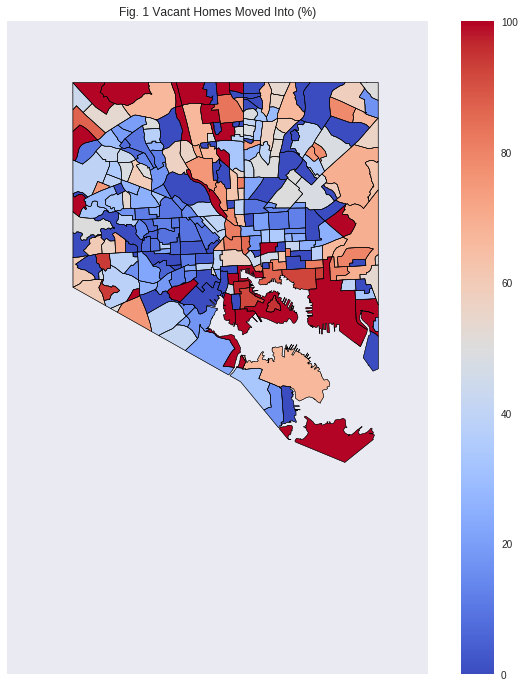

In [252]:
fig=plt.figure(figsize=(12,12))
norm = mpl.colors.Normalize(0,100)
color_producer2=mpl.cm.ScalarMappable(norm=norm,cmap=cmap)
color_producer2.set_array(np.linspace(0,100,20))
map = Basemap(llcrnrlon=-76.75,llcrnrlat=39.1,urcrnrlon=-76.5,urcrnrlat=39.4,projection='lcc', lat_0=39.25, lon_0=-76.65)
map.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
ax3=plt.gca()
for index,row in NH_df.iterrows():
    for i, x in enumerate(basemap_nhs):
        if x==row.Name:
            seg=map.hoods[i]
            polycolor=color_producer2.to_rgba(row.filled_o_vac)
            poly=Polygon(seg, facecolor=polycolor, edgecolor='black')
            ax3.add_patch(poly)
ax3.set_title('Fig. 1 Vacant Homes Moved Into (%)')
plt.colorbar(color_producer2,ax=ax3)
plt.show()


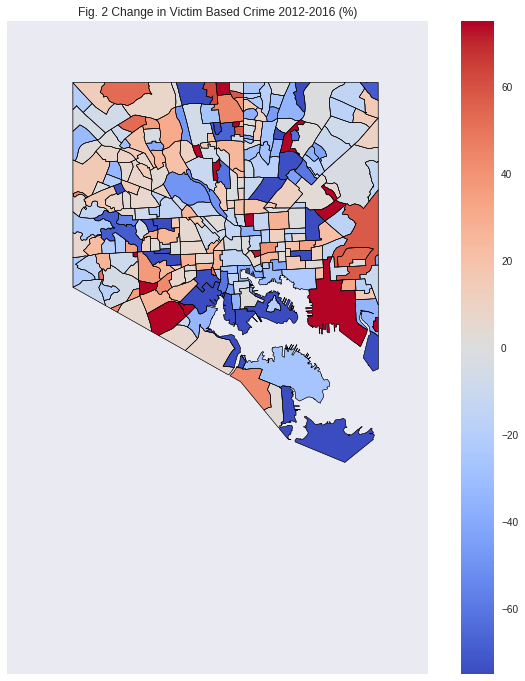

In [258]:
fig=plt.figure(figsize=(12,12))
map = Basemap(llcrnrlon=-76.75,llcrnrlat=39.1,urcrnrlon=-76.5,urcrnrlat=39.4,projection='lcc', lat_0=39.25, lon_0=-76.65)
map.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
ax1=plt.gca()
for index,row in NH_df.iterrows():
    for i, x in enumerate(basemap_nhs):
        if x==row.Name:
            seg=map.hoods[i]
            polycolor=color_producer.to_rgba(row.vict_crime_change)
            poly=Polygon(seg, facecolor=polycolor, edgecolor='black')
            #if meta['vict_crime_change']==np.nan:
             #   poly=Polygon(seg, facecolor='grey',edgecolor='grey')
            #elif meta['vict_crime_change']<0:
            #    poly=Polygon(seg, facecolor='green',edgecolor='green')
            #else:
            #    poly=Polygon(seg, facecolor='red',edgecolor='red')
            ax1.add_patch(poly)
ax1.set_title('Fig. 2 Change in Victim Based Crime 2012-2016 (%)')
plt.colorbar(color_producer,ax=ax1)
plt.show()

            

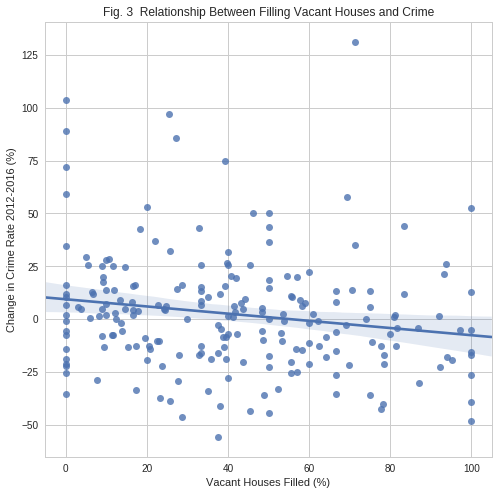

In [263]:
fig=plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
ax=sns.regplot(x='filled_o_vac',y='vict_crime_change',data=NH_df[NH_df.Vacant>20])
ax.set(xlabel='Vacant Houses Filled (%)', ylabel='Change in Crime Rate 2012-2016 (%)')
ax.set_title('Fig. 3  Relationship Between Filling Vacant Houses and Crime')
plt.show()

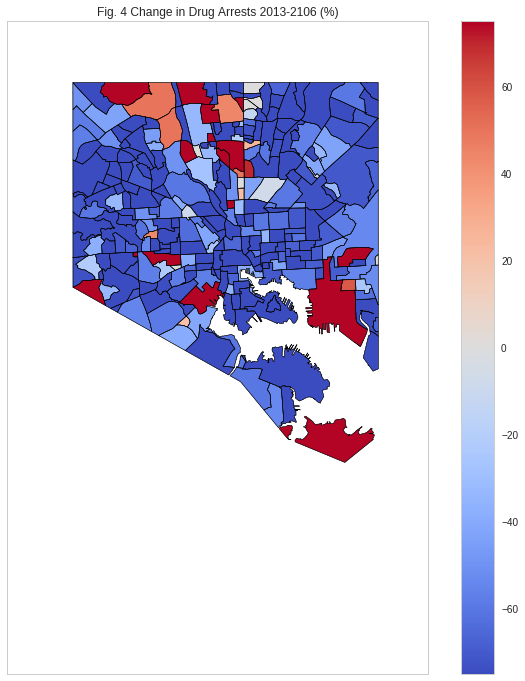

In [261]:
fig=plt.figure(figsize=(12,12))
map = Basemap(llcrnrlon=-76.75,llcrnrlat=39.1,urcrnrlon=-76.5,urcrnrlat=39.4,projection='lcc', lat_0=39.25, lon_0=-76.65)
map.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
ax2=plt.gca()
for index,row in NH_df.iterrows():
    for i, x in enumerate(basemap_nhs):
        if x==row.Name:
            seg=map.hoods[i]
            polycolor=color_producer.to_rgba(row.drug_crime_change)
            poly=Polygon(seg, facecolor=polycolor, edgecolor='black')
            ax2.add_patch(poly)
ax2.set_title('Fig. 4 Change in Drug Arrests 2013-2106 (%)')
plt.colorbar(color_producer,ax=ax2)
plt.show()

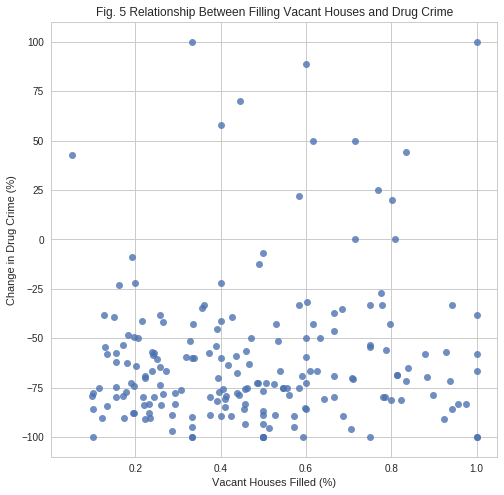

In [264]:
fig=plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
ax=sns.regplot(x='vac_change',y='drug_crime_change',data=NH_df[(NH_df.Vacant>20) & (NH_df.vac_change>0)])
ax.set(title='Fig. 5 Relationship Between Filling Vacant Houses and Drug Crime')
ax.set(xlabel='Vacant Houses Filled (%)',ylabel='Change in Drug Arrests(%)')
plt.show()

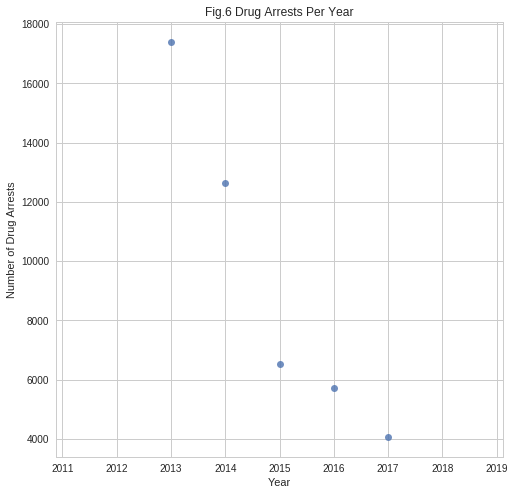

In [267]:
fig=plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
arr_by_year_drugs=arrest_df[arrest_df.is_drugs==True].groupby('year').count()
arr_by_year_drugs['years']=[2013,2014,2015,2016,2017]
ax=sns.regplot(x='years',y='arrestdate',data=arr_by_year_drugs,fit_reg=False)
ax.set(xlabel='Year',ylabel='Number of Drug Arrests',title='Fig.6 Drug Arrests Per Year')
plt.show()